In [1]:
#   Uncomment line below if PyPlot isn't installed in you v0.6.0 .julia environment 
#   This system assumes usage of Python2.7 in your .julia environment
# Pkg.add("PyPlot")
using PyPlot

INFO: Recompiling stale cache file /Users/ilanfilonenko/.julia/lib/v0.6/FixedPointNumbers.ji for module FixedPointNumbers.
INFO: Recompiling stale cache file /Users/ilanfilonenko/.julia/lib/v0.6/ColorTypes.ji for module ColorTypes.
INFO: Recompiling stale cache file /Users/ilanfilonenko/.julia/lib/v0.6/Colors.ji for module Colors.
INFO: Recompiling stale cache file /Users/ilanfilonenko/.julia/lib/v0.6/PyPlot.ji for module PyPlot.


In [2]:
push!(LOAD_PATH,"/Users/ilanfilonenko/.julia/v0.6/FixedPointNumbers")

3-element Array{Any,1}:
 "/Applications/Julia-0.6.app/Contents/Resources/julia/local/share/julia/site/v0.6"
 "/Applications/Julia-0.6.app/Contents/Resources/julia/share/julia/site/v0.6"      
 "/Users/ilanfilonenko/.julia/v0.6/FixedPointNumbers"                              

In [3]:
LOAD_PATH

3-element Array{Any,1}:
 "/Applications/Julia-0.6.app/Contents/Resources/julia/local/share/julia/site/v0.6"
 "/Applications/Julia-0.6.app/Contents/Resources/julia/share/julia/site/v0.6"      
 "/Users/ilanfilonenko/.julia/v0.6/FixedPointNumbers"                              

In [4]:
using FixedPointNumbers

In [5]:
# generate the data
srand(424242)
d = 20;
N = 10000;
wtrue = randn(d);
wtrue = d^2 * wtrue / norm(wtrue);
X = randn(N, d);
X ./= sqrt.(sum(X.^2, 2));
Y = (1 ./ (1 + exp.(-X * wtrue)) .>= rand(N)) * 2 - 1;
sigma = 0.001;
mu = sigma;
L = sigma + 0.25;
M = 1;

What is the optimal step size for SGD under these conditions?
Well, from Lecture 2, we had
$$\alpha_t = \frac{2 \mu \| w_0 - w^* \|^2}{4 M + \mu^2 \| w_0 - w^* \|^2 t}$$
or
$$\alpha_t = \frac{\alpha_0}{1 + \gamma t}$$
where
$$\alpha_0 = \frac{2 \mu \| w_0 - w^* \|^2}{4 M}$$
and
$$\gamma = \frac{\mu^2 \| w_0 - w^* \|^2}{4 M}.$$

In [6]:
w0 = randn(d);

In [7]:
function sgd_logreg(w0, alpha0, gamma, X, Y, sigma, niters, wopt)
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters)
    for k = 1:niters
        alpha = alpha0 / (1 + gamma * (k-1));
        i = rand(1:N)
        xi = X[i,:];
        yi = Y[i];
        w = (1 - alpha * sigma) * w + alpha * xi * yi / (1 + exp(yi * dot(xi, w)));
        dist_to_optimum[k] = norm(w - wopt);
    end
    return (w, dist_to_optimum);
end

sgd_logreg (generic function with 1 method)

In [8]:
# find the true minimum
function newton_logreg(w0, X, Y, sigma, niters)
    N = size(X, 1);
    d = size(X, 2);
    w = w0;
    for k = 1:niters
        g = -X' * (Y ./ (1 + exp.(Y .* (X * w)))) + N * sigma * w;
        H = X' * ((1 ./ ((1 + exp.(Y .* (X * w))) .* (1 + exp.(-Y .* (X * w))))) .* X) + N * sigma * eye(d);
        w = w - H \ g;
        println("gradient norm: $(norm(g))")
    end
    return w
end

newton_logreg (generic function with 1 method)

In [156]:
wopt = newton_logreg(wtrue, X, Y, sigma, 10);

gradient norm: 3999.9774577369785
gradient norm: 896.3972587628688
gradient norm: 233.8971551211784
gradient norm: 59.37077071898397
gradient norm: 5.959623034633464
gradient norm: 0.06910877657917236
gradient norm: 9.433183373722613e-6
gradient norm: 2.815476558090761e-13
gradient norm: 1.1087031992548823e-13
gradient norm: 5.856676381288377e-14


In [157]:
wopt

20-element Array{Float64,1}:
 -4.07134 
 -3.97299 
 -2.51662 
 -5.31225 
  2.39247 
  3.64471 
 -3.25345 
  0.356133
 -2.46952 
 -4.30811 
 -1.27614 
 -1.91754 
 -2.94092 
 -2.00259 
  0.760365
  2.40765 
 -4.04986 
 -1.99684 
 -0.116533
 -0.125707

In [124]:
alpha0 = 2 * mu * norm(w0 - wopt)^2 / (4 * M);
gamma = mu^2 * norm(w0 - wopt)^2 / (4 * M);

In [ ]:
srand(123456);
(w, dto) = sgd_logreg(w0, alpha0, gamma, X, Y, sigma, 50000, wopt);

In [ ]:
plot(dto)
xlabel("iteration");
ylabel("distance to optimum");

In [ ]:
plot(dto_svrg)

In [118]:
function svrg(w0, alpha, X, Y, sigma, niters, nepochs, wopt)
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters * nepochs)
    for epi = 1:nepochs
        wtilde = w;
        gtilde = X' * (Y ./ (1 + exp.(Y .* (X * wtilde)))) / N - sigma * wtilde;
        for k = 1:niters
            i = rand(1:N)
            xi = X[i,:];
            yi = Y[i];
            w = w + alpha * (xi * yi / (1 + exp.(yi * dot(xi, w))) - sigma * w - xi * yi / (1 + exp(yi * dot(xi, wtilde))) + sigma * wtilde + gtilde);
            dist_to_optimum[k + (epi-1)*niters] = norm(w - wopt);
        end
    end
    return (w, dist_to_optimum);
end

svrg (generic function with 1 method)

In [ ]:
srand(123456);
(w2, dto2) = sgd_logreg(w0, 2*alpha0, 4*gamma, X, Y, sigma, 50000, wopt);
srand(123456);
(w2, dto3) = sgd_logreg(w0, 3*alpha0, 9*gamma, X, Y, sigma, 50000, wopt);
srand(123456);
# (w, dto_svrg) = svrg(w0, alpha, X, Y, sigma, T, K, wopt);

In [ ]:
semilogy(dto; label = "optimal step size")
semilogy(dto2; label = "2x optimal")
semilogy(dto3; label = "3x optimal")
semilogy(dto_svrg; label = "SVRG")
xlabel("iteration");
ylabel("distance to optimum");
legend();

In [ ]:
(w, dto_svrg) = svrg(w0, alpha0, X, Y, sigma, 100, 2, wopt);

Must generate a training set at random from the generative model associated with logistic regression.
This generative model is, for label $y \in \{-1,1\}$, features $x \in \mathbb{R}^d$ and model $w \in \mathbb{R}^d$,

$$\mathbf{P}_w(y | x) = \frac{1}{1 + \exp(-y x^T w)}.$$

Since $$\phi_{k,i} = x_i^T w.$$

$$p(\phi) = \prod_{i=1}^N \frac{1}{1 + \exp(y_i \phi_{k,i})}$$

and so maximizing this is equivalent to maximizing the log likelihood

$$\log p(\phi) = -\sum_{i=1}^N \log \left( 1 + \exp(y_i \phi_{k,i}) \right).$$

The gradient of this is

$$\nabla \log p(\phi) = \sum_{i=1}^N \frac{y_i}{1 + \exp(y_i \phi_{k,i})}.$$

Anyway, we can see that this corresponds to logistic regression.

Optimal step size from our analysis was
$$\alpha = \frac{\mu}{5 L^2 e}$$
and optimal epoch length was
$$T = \frac{5 L^2 e}{\mu^2}$$.

In [10]:
alpha = mu / (5 * L^2 * e);
T = Int64(ceil(5 * L^2 * e / (mu^2)));
K = 10;

In [92]:
log_loss = ((p,i) -> log(1 + exp.(-Y[i] * p[i])));
g_log_loss = ((p,i) -> (Y[i] / (1 + exp.(-Y[i] * p[i]))));

In [ ]:
phi_0 = map(i -> X[i,:]'*w0, collect(1:N));
# a = g_log_loss(phi_0,1)*X[1,:]
# b = g_log_loss(phi_0,2)*X[2,:]

In [ ]:
red_box = Scaled{Int16,15,1./1000.0,Randomized}

In [ ]:
g = mapreduce(i->g_log_loss(phi_0,i)*X[i,:], +, collect(1:N));
s = norm(g)./(mu*(2^(8-1)-1))

In [ ]:
s1 = 7438.767705355814
s2 = 0.11350658730096151
log2(s1/s2)
subdomain(Scaled{Int8,7,s1,Randomized},Scaled{Int32,22,s2,Randomized})

In [ ]:
zeros(Scaled{Int8,7,1.0,Randomized},5)

In [141]:
bit_dict = Dict(8 => Int8, 16 => Int16, 32 => Int32, 64 => Int64)
function lm_halp(w0, alpha, X, Y, T, K, wopt, mu, b, 
    r_b,r_s,p_b,grad_l)
    #######################
    # General function for LM-HALP
    #
    #
    #
    #
    #######################
    w = w0 # initializing w with initial iterate w0
    (N, d) = size(X)
    z = zeros(d) # initializing z in full precision
    dist_to_optimum = zeros(T*K)
    s = 1.0
    blue_box = Float64
    red_box = Scaled{bit_dict[r_b],r_b-1,r_s,Randomized}
    X = convert(Array{red_box}, X)
    for k = 1:K
        w = w + z;
        println("Iteration($k): $(norm(w-wopt))")
        phi = map(i -> X[i,:]'*w, 1:N)
        gtilde = mapreduce(i->grad_l(phi,i)*X[i,:], +, 1:N)
        s = norm(gtilde)/(mu*(2^(b-1)-1))
        blue_box = Scaled{bit_dict[b],b-1,s,Randomized}
        p_s = (s./r_s)*2.0^(b-r_b-p_b)
        purple_box = Scaled{bit_dict[p_b],p_b-1,p_s,Randomized}
        green_box = red_box*purple_box
        assert(subdomain(blue_box,green_box))
        htilde = convert(Array{green_box}, alpha*gtilde)
        z = zeros(blue_box,d)
        for t = 1:T
            i = rand(1:N)
            inner_l = grad_l((phi+X[i,:]'*z),i)
            inner_purple = alpha.*(inner_l-grad_l(phi,i))
            i_g = convert(Array{green_box},purple_box(inner_purple).*X[i,:])
            z = convert(Array{green_box}, float(z))
            z = convert(Array{blue_box}, float(z - i_g - htilde))
            dist_to_optimum[t + (k-1)*T] = norm(w+z - wopt);
        end
    end
    return (w, dist_to_optimum);
end

lm_halp (generic function with 1 method)

In [142]:
T

856273

In [154]:
srand(123456);
(w, dto_lm_halp) = lm_halp(w0, alpha0/1000, X, Y, 100, 5, wopt, mu, 16, 32, 1./128000, 16, 
g_log_loss);
(w, dto_svrg) = svrg(w0, alpha0, X, Y, sigma, 100, 2, wopt);

Iteration(1): 12.947623679424868
Iteration(2): 50.81255414264946
Iteration(3): 50.81255414264946
Iteration(4): 68.52151020193435
Iteration(5): 68.52151020193435


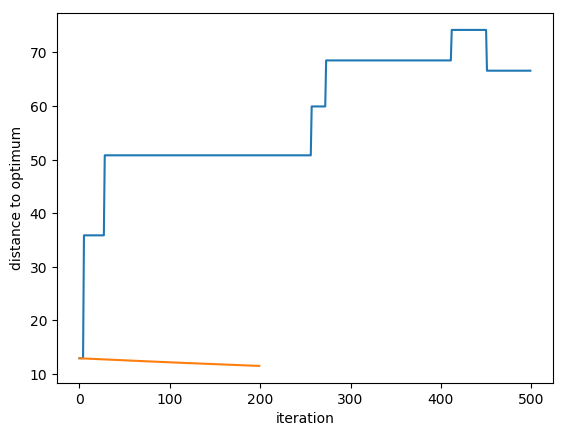

In [155]:
plot(dto_lm_halp)
plot(dto_svrg)
xlabel("iteration");
ylabel("distance to optimum");

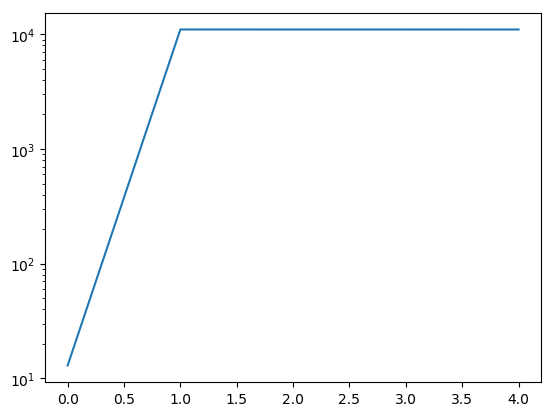

In [83]:
semilogy(dto_lm_halp);

In [ ]:
bit_dict[8]

In [ ]:
time1 = @timed (w, dto_svrg) = svrg(w0, alpha, X, Y, sigma, T, K, wopt);

In [ ]:
time2 = @timed (w2, dto_svrg2) = svrg(w0, 3*alpha, X, Y, sigma, Int64(ceil(T)), K, wopt);

In [ ]:
semilogy(dto_svrg; label = "optimal", color = "blue");
semilogy(dto_svrg2; label = "3x step size", color = "red");
xlabel("inner iteration")
ylabel("distance to optimum")
legend();

In [ ]:
semilogy(collect(1:length(dto_svrg)) / length(dto_svrg) * time1[2], dto_svrg; label = "optimal", color = "blue");
semilogy(collect(1:length(dto_svrg2)) / length(dto_svrg2) * time2[2], dto_svrg2; label = "3x step size", color = "red");
xlabel("wall clock time (seconds)")
ylabel("distance to optimum")
legend();

In [ ]:
srand(123456);
time3 = @timed (w3, dto_svrg3) = svrg(w0, 3.0 * alpha, X, Y, sigma, Int64(ceil(T / 2)), K, wopt);

In [ ]:
semilogy(dto_svrg2; label = "3x step size", color = "red");
semilogy(dto_svrg3; label = "50% epoch, 3x step size", color = "green");
xlabel("inner iteration")
ylabel("distance to optimum")
legend();

In [ ]:
semilogy(collect(1:length(dto_svrg2)) / length(dto_svrg2) * time2[2], dto_svrg2; label = "3x step size", color = "red");
semilogy(collect(1:length(dto_svrg3)) / length(dto_svrg3) * time3[2], dto_svrg3; label = "50% epoch, 3x step size", color = "green");
xlabel("wall clock time (seconds)")
ylabel("distance to optimum")
legend();